<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>

<H3 align='center'> Tarea 3 - Ensamblados y modelos avanzados </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Técnicas de ensamblado: *bagging*, *boosting* y *random forest*.
* Ventajas de técnicas de ensamblados
* Problemas desbalanceados
 

**Formalidades**  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y cierre competencia: 17 de Enero
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF393-II-2019]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Ensamblados para regresión  
[2.](#segundo) Detección de acoso en *Twitter*  

<a id="primero"></a>
## 1. Ensamblados para regresión
---
Las técnicas de ensamblados vistos en clases pueden ser aplicadas tanto a problemas de clasificación o regresión, teniendo la ventaja de utilizar múltiples modelos de aprendizaje para utilizar la ventaja de cada uno. En este actividad se trabajará con predecir la temperatura media de un día, dada cierta información del día anterior, como la humedad, velocidad del viento, presión atmosférica, fecha y temperatura. El modelo predictor derivado puede ser bastante útil para conocer el comportamiento del clima a lo largo del tiempo.

<img src="https://scijinks.gov/review/forecast-reliability/forecast-reliability2.jpg" title="Title text" width="70%"  />

Los datos de clima son recolectados en la ciudad Delhi de India por un período de 4 años (2013 a 2017), proporcionados en Kaggle a través del siguiente __[link](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)__, las particiones de entrenamiento y prueba están dadas. El registro de cada dato corresponde a un día, incrementando a través de las filas por cada día.

---
    
>  Cargue los datos en un dataframe de pandas, además agregue una columna indicando el valor a predecir, la temperatura media del día siguiente. *Como el último dato/registro no tiene un valor a predecir éste se elimina*.
```python
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row
```

In [1]:
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row
df

,date,meantemp,humidity,wind_speed,meanpressure,y_value
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.400000
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,7.166667
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,8.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,6.000000
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,7.000000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000,7.000000
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000,8.857143
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286,14.000000
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000,11.000000
9,2013-01-10,11.000000,62.000000,7.400000,1015.666667,15.714286


> Debido a la poca información que se tiene a través de los 4 parámetros medidos, extraíga más información a través de los datos de fecha. Por ejemplo, el comportamiento a través de los meses y años varía, así como la información de la temporada del año podría ayudar a la predicción. Decida si puede incluir más información a partir de la fecha que tenga sentido con el problema.
```python
...#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
df.drop(["date"], axis=1, inplace=True) #delete date
```

In [2]:
#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
#any more information?
df.drop(["date"], axis=1, inplace=True) #delete date
df

,meantemp,humidity,wind_speed,meanpressure,y_value,cday,year,month,season_fall,season_rainy,season_summer,season_winter
0,10.000000,84.500000,0.000000,1015.666667,7.400000,1,2013,1,0,0,0,1
1,7.400000,92.000000,2.980000,1017.800000,7.166667,2,2013,1,0,0,0,1
2,7.166667,87.000000,4.633333,1018.666667,8.666667,3,2013,1,0,0,0,1
3,8.666667,71.333333,1.233333,1017.166667,6.000000,4,2013,1,0,0,0,1
4,6.000000,86.833333,3.700000,1016.500000,7.000000,5,2013,1,0,0,0,1
5,7.000000,82.800000,1.480000,1018.000000,7.000000,6,2013,1,0,0,0,1
6,7.000000,78.600000,6.300000,1020.000000,8.857143,0,2013,1,0,0,0,1
7,8.857143,63.714286,7.142857,1018.714286,14.000000,1,2013,1,0,0,0,1
8,14.000000,51.250000,12.500000,1017.000000,11.000000,2,2013,1,0,0,0,1
9,11.000000,62.000000,7.400000,1015.666667,15.714286,3,2013,1,0,0,0,1


> Cree las matrices de entrenamiento, con los mil primeros registros, y de validación, con el resto. Para evitar el orden natural en que vienen los datos entrenados, realice un *shuffle* aleatorio.
```python
y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only
```

In [3]:
y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only

> a) Describa el problema trabajado, la cantida de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.


> b) Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol **no regularizado** (como el que no tiene límites en su profundidad) y otro Árbol **regularizado** (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar *split* o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?
```python
import numpy as np
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)
... #define your regularized tree model
``` 

In [4]:
import numpy as np
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)
model_unr.score(X_val, y_val)

0.8903983696050223

> c) Para evaluar la calidad de predicción en este problema se utilizará la métrica *Root Mean Squared Error* (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización *vs* el no regularizar.
```python
y_train_hat = model.predict(X_train)
y_val_hat = model.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()
```

In [5]:
y_train_hat = model_unr.predict(X_train)
y_val_hat = model_unr.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

RMSE train=  0.0
RMSE val=  2.3456541587455075


<Figure size 800x500 with 1 Axes>

> d) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **Bagging**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en b)*) ¿Qué debería suceder? ¿Se visualiza *overfitting*? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.
```python
from sklearn.ensemble import BaggingRegressor
model = BaggingRegressor(base_estimator=Tree(...), n_estimators=..., n_jobs=-1)
```

> e) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **AdaBoost**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en d)* ¿Se visualiza *overfitting*? ¿Qué técnica utiliza la librería de sklearn, *re-muestrear* o *pesar* ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).
```python
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor(base_estimator=Tree(...), n_estimators=...)
```

> f) Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo *boostrap* de *Bagging* con muestreo sobre las *features*: **Random Forest**, compare el Árbol **no regularizado** con el **regularizado** ¿Se visualiza *overfitting*?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.
```python
from sklearn.ensemble import RandomForestRegressor
model_unr = RandomForestRegressor(n_estimators=..., n_jobs=-1)
... #define your regularized random forest model
```

> g) Verifique que el **OOB error** (*out of bag error*) de los ensambladores que utilizan la técnica *boostrap* puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto *cross validation*).
```python
oob_error = model.oob_score_
val_error = model.score(X_val,y_val)
print("OOB error: ",oob_error)
print ("Val error: ",val_error)
```

> h) Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo *Bagging* realiza el voto de la mayoría para clasificación y promedio para regresión, *AdaBoost* realiza una combinación ponderada de cada clasificador dependiendo de su *habilidad* (desempeño para clasificar el conjunto de entrenamiento). Se puede inspirar desde clásicos estadísticos, como entregar el primer cuartíl ($Q_1$) si al ensamblado le cuesta predecir valores bajos, o el segundo cuartil ($Q_2$) o mediana para ser robusto a predicciones atípicas de modelos.  
```python
def combine_predictions(predictions):
    return #define !
list_estimators = model.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
new_predictions = combine_predictions(list_predictions)
print("RMSE val= ",RMSE(y_val, new_predictions))
```

> i) Si se cuenta con una gran cantidad de modelos en el ensamblado, por ejemplo $T>100$, se puede crear un intervalo de confianza de la predicción a través de todos estos valores, asumiendo una distribución Normal centrada en la media muestral de las predicciones, con desviación estándar muestral en las predicciones. El intervalo de confianza entrega más información que un único valor puntual de predicción. Visualice un intervalo de confianza al 95% de probabilidad en la predicción a lo largo de la serie de tiempo de validación, comente. Al asumir una distribución Normal, también puede explorar el tomar como predicción del ensamblado el muestreo sobre la distribución Normal creada entorno a los datos muestrales.
```python
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(8,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()
```

>  j) Evalúe y visualice la predicción del mejor modelo encontrado para resolver este problema, en el conjunto de pruebas. Además, compare y analice las distintas maneras con las que se resolvió el problema, incluya las decisiones que conlleva y los resultados que reflejan.
```python
df = pd.read_csv("DailyDelhiClimateTest.csv")
```

<a id="segundo"></a>
## 2. Detección de acoso en *Twitter*
---
En las redes sociales muchas veces se encuentra con un cierto comportamiento indeseable para los usuarios, tal como racismo, misógeno, grupos de odio o *trolls*. El poder detectar de manera automática ciertos patrones en el comportamiento para tomar una acción debe ser crucial para reducir el tiempo y esfuerzo humano. En esta actividad se trabajará sobre *tweets* la red social de *twitter* para detectar comportamiento *online* de acoso (*harassment*), que por lo general, incluye *flaming* como lenguaje abusivo o insultos, *doxing* como mostrar la información personal de una mujer, por ejemplo el domicilio o número de teléfono, la suplantación o la vergüenza pública por destruir la reputación de las personas.

<img src="https://kidshelpline.com.au/sites/default/files/bdl_image/header-T-OH.png" title="Title text" width="45%"  />

En algunos problemas como este, el comportamiento a detectar puede ser asociado a una anomalía (*outlier*) del comportamiento normal de los usuarios en las redes sociales. Esto es una de las causas de la dificultad del problema, puesto que es **altamente desbalanceado**, donde aproximadamente un 10% de los *tweets* corresponden a acoso (*harassment*).

Los datos trabajados corresponderan a *tweets* etiquetados como *harassment* (con valor 1) o no (con valor 0) -- la tarea a detectar--. Además si desea utilizar, se incluye la información del tipo de *harassment* en el conjunto de entrenamiento como atributos extras. El conjunto de pruebas solo contiene los *tweets* a ser etiquetados.



## Carga de datos

Using TensorFlow backend.


            tweet_content
harassment               
0                    5154
1                     549


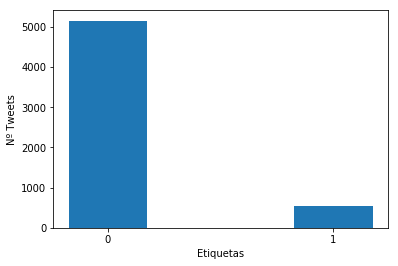

In [6]:
import math
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC


#Test Set
df_test = pd.read_csv("tarea3-ml/Test_input.csv", encoding='ISO-8859-1')
df_test_content = df_test.tweet_content
y_test = pd.read_csv('tarea3-ml/sample_submission.csv')
y_test = y_test.harassment
#Train Set
df_train = pd.read_csv("tarea3-ml/Train_data.csv", encoding='ISO-8859-1')
df_train = df_train.drop(columns=['id','IndirectH', 'PhysicalH', 'SexualH'])
df_train_content = df_train.tweet_content
labels_train = df_train.harassment

tweet_by_harassment = df_train.groupby(['harassment']).count()
print(tweet_by_harassment)
plt.bar(['0','1'], tweet_by_harassment['tweet_content'], 0.35)
plt.xlabel('Etiquetas')
plt.ylabel('Nº Tweets')
plt.show()

Se observa que hay un desequilibrio entre las clases muy grande 5154 tweets sin acoso vs 549, por lo que habra que tener cuidado con el comportamiento de predicción de la clase 1.

Es por esto que tambien se aplicaran técnicas para el manejo de datos desbalanceados, como lo son:
* Eliminar muestras de la clase mayoritaria (**subsampling**): Tiene un punto en contra en que podriamos prescindir de muestras importantes.
* Muestras Artificiales (**oversampling**): Intentar crear muestras sinteticas de la clase minoritaria tiene el punto encontra en que podemos cambiar la distribución natural de la clase y por tanto incurrir en altos errores de clasificación.

## Limpieza de comentarios

In [7]:
import re, time
import nltk
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize

def base_word(word):
    wordlemmatizer = WordNetLemmatizer()
    return wordlemmatizer.lemmatize(word) 
def word_extractor(text_input):
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text_input) #substitute multiple letter by two
    words = ""
    wordtokens = [ base_word(word.lower()) for word in word_tokenize(text) ]
    
    for word in wordtokens:
        if word not in commonwords: #and len(word)>3:  #delete stopwords and emogis
            words+=" "+word
    if len(words) == 0:
        print(text_input)
    return words

In [8]:
content_train = [word_extractor(tweet) for tweet in df_train_content]
content_test = [word_extractor(tweet) for tweet in df_test_content]

## Representación Term Frecuency

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer= CountVectorizer(ngram_range=(1, 1), binary=False)
vectorizer.fit(content_train)

features_train = vectorizer.transform(content_train)
features_test = vectorizer.transform(content_test)

features_train.shape

(5703, 14863)

Se observa que se cuenta con un vocabulario de 14863 palabras, y por tanto tambien se tendra una alta dimensionalidad del problema. Es muy probable que los árboles de decisiones no funcionen con esta representación.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from  sklearn.metrics import f1_score
from imblearn.ensemble import BalancedBaggingClassifier # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import classification_report

#Regresion Logistica
model= LogisticRegression()
model.set_params(penalty='l2',C=1)
model.fit(features_train,labels_train)
y_pred = model.predict(features_test)

print(classification_report(y_test, y_pred))
print(f'Acc: {model.score(features_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.50      0.96      0.66       899
           1       0.44      0.03      0.06       886

    accuracy                           0.50      1785
   macro avg       0.47      0.50      0.36      1785
weighted avg       0.47      0.50      0.36      1785

Acc: 0.4997198879551821
f1-score: 0.05702217529039071


In [11]:
#Bagging Con Árbol de decision
model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=20)
model.fit(features_train, labels_train)
y_pred = model.predict(features_test)

print(classification_report(y_test, y_pred))
print(f'Acc: {model.score(features_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.51      0.77      0.61       899
           1       0.51      0.24      0.32       886

    accuracy                           0.51      1785
   macro avg       0.51      0.50      0.47      1785
weighted avg       0.51      0.51      0.47      1785

Acc: 0.5064425770308123
f1-score: 0.3217859892224788


### Subsampling

In [12]:
from imblearn.under_sampling import NearMiss

underSampling = NearMiss(n_neighbors=10, version=2)
X_train_res, y_train_res = underSampling.fit_sample(features_train, labels_train)

#Regresion Logistica Con Bagging
model = BaggingClassifier(base_estimator=LogisticRegression(penalty='l2',C=10), n_estimators=20, n_jobs=-1).fit(X_train_res, y_train_res)
y_pred = model.predict(features_test)
print(classification_report(y_test, y_pred))
print(f'Acc: {model.score(features_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.50      0.83      0.62       899
           1       0.48      0.16      0.24       886

    accuracy                           0.50      1785
   macro avg       0.49      0.49      0.43      1785
weighted avg       0.49      0.50      0.43      1785

Acc: 0.49635854341736696
f1-score: 0.2361937128292268


### Resampling + Smote-Tomek

In [13]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

os_us = SMOTETomek()
X_train_smote, y_train_smote = os_us.fit_sample(features_train, labels_train)

#Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10)#max_depth=10
rf_model.fit(X_train_smote, y_train_smote)
y_pred = rf_model.predict(features_test)
print(classification_report(y_test, y_pred))
print(f'Acc: {rf_model.score(features_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.50      0.58      0.54       899
           1       0.50      0.42      0.45       886

    accuracy                           0.50      1785
   macro avg       0.50      0.50      0.50      1785
weighted avg       0.50      0.50      0.50      1785

Acc: 0.5002801120448179
f1-score: 0.45276073619631907


In [14]:
#SVM + Bagging
model = BaggingClassifier(base_estimator=SVC(kernel='linear', C=0.001), n_estimators=100, n_jobs=-1)
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(features_test)
print(classification_report(y_test, y_pred))
print(f'Acc: {model.score(features_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.53      0.12      0.20       899
           1       0.50      0.89      0.64       886

    accuracy                           0.50      1785
   macro avg       0.52      0.51      0.42      1785
weighted avg       0.52      0.50      0.42      1785

Acc: 0.503641456582633
f1-score: 0.6410048622366289


## Word Vectors

In [15]:
from operator import itemgetter
EMBEDDING_DIM = 300
GLOVE_FILE = f"glove/glove.6B.{EMBEDDING_DIM}d.txt"
embeddings_index = {}
with open(GLOVE_FILE, encoding="utf8") as file:
    for line in file:
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

In [16]:
def generate_columns(sentences_vector):
    c = 0
    list_aux = []
    matrix_n = np.empty((0,0))
    for row in sentences_vector:
        matrix = np.empty((0,0))
#         print("2***********************")
        for word in row.split():
#             print('***************************************************************************')
            embd = embeddings_index.get(word)
#             if embd is not None:
#                 print(f'embd:{embd}')
            if embd is None:
                embd = np.zeros(300)
                matrix = embd[np.newaxis,:] if matrix.shape == (0,0) else np.concatenate((matrix, embd[np.newaxis,:]), axis = 0)       
            else:
                matrix = embd[np.newaxis,:] if matrix.shape == (0,0) else np.concatenate((matrix,embd[np.newaxis,:]), axis = 0)
#         print(f'matrix: {matrix} fin matrix')
#         print(f'row: {rows}')
        word_caracs = 0
        if len(row) == 0:
            word_caracs = np.zeros(300)
        else:
            word_caracs = matrix.mean(0)
        matrix_n = word_caracs[np.newaxis,:] if matrix_n.shape == (0,0) else np.concatenate((matrix_n, word_caracs[np.newaxis,:]),
                                                                                            axis = 0)
        c+=1     
    new_df = pd.DataFrame(list_aux)
    return matrix_n

In [17]:
Train_feature = generate_columns(content_train)
Test_feature = generate_columns(content_test)

### Subsampling 

In [18]:
from imblearn.under_sampling import NearMiss

underSampling = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = underSampling.fit_sample(Train_feature, labels_train)

In [19]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
## Random Forest
rf_model = RandomForestClassifier(n_estimators=20, max_depth=10)#max_depth=10
rf_model.fit(X_train_res, y_train_res)
y_pred = rf_model.predict(Test_feature)
print(classification_report(y_test, y_pred))
print(f'Acc: {rf_model.score(Test_feature, y_test)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.50      0.17      0.25       899
           1       0.50      0.83      0.62       886

    accuracy                           0.50      1785
   macro avg       0.50      0.50      0.44      1785
weighted avg       0.50      0.50      0.43      1785

Acc: 0.4969187675070028
f1-score: 0.6217354675652907


In [20]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

#Regresion Logistica + Bagging
model = BaggingClassifier(base_estimator=LogisticRegression(penalty='l2',C=0.9), n_estimators=100, n_jobs=-1).fit(X_train_res, y_train_res)
y_pred = model.predict(Test_feature)
f1_score(y_test, y_pred, average='binary')
print(classification_report(y_test, y_pred))
print(f'Acc: {model.score(Test_feature, y_test)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.50      0.42      0.46       899
           1       0.49      0.58      0.53       886

    accuracy                           0.50      1785
   macro avg       0.50      0.50      0.49      1785
weighted avg       0.50      0.50      0.49      1785

Acc: 0.49635854341736696
f1-score: 0.5315268368942158


In [21]:
df_aux = pd.DataFrame()
df_aux["id"] = np.arange(1, 1+y_pred.shape[0])
df_aux["harassment"] = y_pred.astype('int')
df_aux.to_csv("test_estimation6.csv", index=False)
print('termino')

termino


In [22]:
#Ensamble de Modelos con Balanceo
model = BalancedBaggingClassifier(base_estimator=SVC(kernel='linear'), n_estimators=10)
model.fit(X_train_res, y_train_res)
y_pred = model.predict(Test_feature)
print(classification_report(y_test, y_pred))
print(f'Acc: {model.score(Train_feature, labels_train)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.50      0.47      0.49       899
           1       0.49      0.52      0.51       886

    accuracy                           0.50      1785
   macro avg       0.50      0.50      0.50      1785
weighted avg       0.50      0.50      0.50      1785

Acc: 0.6747325968788357
f1-score: 0.5087719298245613


In [23]:
#Regresion Logistica Sola
model= LogisticRegression()
model.set_params(penalty='l2', class_weight="balanced")
model.fit(X_train_res,y_train_res)

y_pred = model.predict(Test_feature)
print(classification_report(y_test, y_pred))
print(f'Acc: {model.score(Train_feature, labels_train)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.50      0.40      0.45       899
           1       0.49      0.59      0.54       886

    accuracy                           0.50      1785
   macro avg       0.50      0.50      0.49      1785
weighted avg       0.50      0.50      0.49      1785

Acc: 0.6484306505348062
f1-score: 0.5362840967575914


In [24]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(base_estimator =LogisticRegression(penalty='l2',C=10), n_estimators=100, random_state=0)
clf.fit(X_train_res, y_train_res)

y_pred = model.predict(Test_feature)
print(classification_report(y_test, y_pred))
print(f'Acc: {clf.score(Test_feature, y_test)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.50      0.40      0.45       899
           1       0.49      0.59      0.54       886

    accuracy                           0.50      1785
   macro avg       0.50      0.50      0.49      1785
weighted avg       0.50      0.50      0.49      1785

Acc: 0.49523809523809526
f1-score: 0.5362840967575914


### Oversampling 

In [25]:
from imblearn.over_sampling import RandomOverSampler

overSampling =  RandomOverSampler()
X_train_os, y_train_os = overSampling.fit_sample(Train_feature, labels_train)
X_train_os.shape

(10308, 300)

In [26]:
#Random Forest
rf_model = RandomForestClassifier(n_estimators=20)#max_depth=10
rf_model.fit(X_train_os, y_train_os)
y_pred = rf_model.predict(Test_feature)
print(classification_report(y_test, y_pred))
print(f'Acc: {rf_model.score(Test_feature, y_test)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.51      0.99      0.67       899
           1       0.65      0.01      0.02       886

    accuracy                           0.51      1785
   macro avg       0.58      0.50      0.35      1785
weighted avg       0.58      0.51      0.35      1785

Acc: 0.5064425770308123
f1-score: 0.024363233665559245


In [27]:
#Regresion Logistica + Bagging
model = BaggingClassifier(base_estimator=LogisticRegression(penalty='l2',C=0.0001), n_estimators=20, n_jobs=-1)
model.fit(X_train_os, y_train_os)
y_pred = model.predict(Test_feature)
print(classification_report(y_test, y_pred))
print(f'Acc: {model.score(Test_feature, y_test)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.50      0.73      0.59       899
           1       0.50      0.28      0.35       886

    accuracy                           0.50      1785
   macro avg       0.50      0.50      0.47      1785
weighted avg       0.50      0.50      0.48      1785

Acc: 0.5019607843137255
f1-score: 0.3543936092955701


In [28]:
#SVM + Bagging
model = BaggingClassifier(base_estimator=SVC(kernel='linear'), n_estimators=10)
model.fit(X_train_os, y_train_os)
y_pred = model.predict(Test_feature)
print(classification_report(y_test, y_pred))
print(f'Acc: {model.score(Train_feature, labels_train)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.50      0.71      0.59       899
           1       0.49      0.28      0.35       886

    accuracy                           0.50      1785
   macro avg       0.49      0.49      0.47      1785
weighted avg       0.49      0.50      0.47      1785

Acc: 0.8532351394003156
f1-score: 0.35319454414931806


In [29]:
#Regresion Logistica
model= LogisticRegression()
model.set_params(penalty='l2', C=0.01)
model.fit(X_train_os,y_train_os)

y_pred = model.predict(Test_feature)
print(classification_report(y_test, y_pred))
print(f'Acc: {model.score(Train_feature, labels_train)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.50      0.72      0.59       899
           1       0.50      0.28      0.36       886

    accuracy                           0.50      1785
   macro avg       0.50      0.50      0.48      1785
weighted avg       0.50      0.50      0.48      1785

Acc: 0.8337716991057338
f1-score: 0.3571945046999277


### Resampling + Smote-Tomek

In [30]:
from imblearn.combine import SMOTETomek # doctest: +NORMALIZE_WHITESPACE

os_us = SMOTETomek()
X_train_smote, y_train_smote = os_us.fit_sample(Train_feature, labels_train)

#Regresion Logistica + Bagging
model = BaggingClassifier(base_estimator=LogisticRegression(penalty='l2', C=0.001), n_estimators=10)
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(Test_feature)
print(classification_report(y_test, y_pred))
print(f'Acc: {model.score(Train_feature, labels_train)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.50      0.74      0.60       899
           1       0.48      0.25      0.33       886

    accuracy                           0.49      1785
   macro avg       0.49      0.49      0.46      1785
weighted avg       0.49      0.49      0.46      1785

Acc: 0.8183412239172365
f1-score: 0.32786885245901637


In [31]:
#Regresion Logistica
model= LogisticRegression()
model.set_params(penalty='l2', C=1)
model.fit(X_train_smote,y_train_smote)

y_pred = model.predict(Test_feature)
print(classification_report(y_test, y_pred))
print(f'Acc: {model.score(Train_feature, labels_train)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.51      0.76      0.61       899
           1       0.50      0.25      0.34       886

    accuracy                           0.51      1785
   macro avg       0.51      0.50      0.47      1785
weighted avg       0.51      0.51      0.47      1785

Acc: 0.8628791863931264
f1-score: 0.3358433734939759


c:\users\castillo\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [32]:
#Random Forest
rf_model = RandomForestClassifier(n_estimators=20)#max_depth=10
rf_model.fit(X_train_smote, y_train_smote)
y_pred = rf_model.predict(Test_feature)
print(classification_report(y_test, y_pred))
print(f'Acc: {rf_model.score(Test_feature, y_test)}')
print(f'f1-score: {f1_score(y_test, y_pred, average="binary")}')

              precision    recall  f1-score   support

           0       0.51      0.97      0.67       899
           1       0.59      0.04      0.08       886

    accuracy                           0.51      1785
   macro avg       0.55      0.51      0.37      1785
weighted avg       0.55      0.51      0.38      1785

Acc: 0.5103641456582633
f1-score: 0.0819327731092437
